# Waterloo Takeoff Data Source Code

## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
from sklearn.linear_model import LinearRegression

## File Readings and Dataframe Creation

In [3]:
%%time
# Flights from Apr 16 to May 23

subfolders = [f.path for f in os.scandir('data/waterloo/flight/') if f.is_dir()] #Scans Directory
total_subfolders = len(subfolders)

# Stores a csv cols into a list
df_time_list = []
df_kw_list = []
df_alt_list = []
df_soc_list = []
df_oat_list = []

# Iterates and read each csv
for i, subfolder in enumerate(subfolders):
    csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True) #Status Print
    if csv_files:
        # Reads the first csv file in each flight folder
        main_csv = csv_files[0]
        with open(main_csv) as f:
            total_rows = sum(1 for line in f)
        # Skips every 10 rows for efficiency (1 sec iterations estimate)
        skip_rows = [i for i in range(1, total_rows) if i % 10 != 0]
   
    df_csv = pd.read_csv(main_csv,skiprows=skip_rows)
    df_time_list.append(df_csv[" time(min)"])
    df_kw_list.append(df_csv[" motor power"])
    df_soc_list.append(df_csv[" bat 1 soc"])
    df_oat_list.append(df_csv[" OAT"])
    # Calibrates alt to ground alt and converts m to ft
    df_csv[" PRESSURE_ALT"] = (df_csv[" PRESSURE_ALT"]-df_csv[" PRESSURE_ALT"].iloc[-1])*3.28084
    df_csv[" PRESSURE_ALT"] = df_csv[" PRESSURE_ALT"].where(df_csv[" PRESSURE_ALT"]>=0, 0)
    df_alt_list.append(df_csv[" PRESSURE_ALT"])
    
# Main df
df_power = pd.DataFrame({"time": df_time_list, "kw": df_kw_list, "alt": df_alt_list, "soc": df_soc_list, "oat": df_oat_list})
print('')       
    

Processing file data/waterloo/flight/csv-25795-6179 [100%]
CPU times: total: 5.09 s
Wall time: 11.4 s


## Data Visualizations

### Altitude Data From All Flights

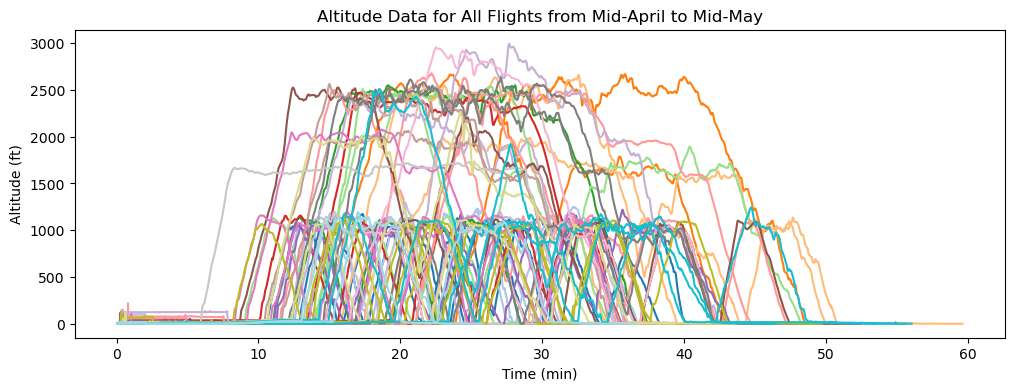

CPU times: total: 234 ms
Wall time: 419 ms


In [15]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))
    #plt.plot(df_power["kw"][i])

plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for All Flights from Mid-April to Mid-May')
plt.show()

### Circuit-Fitlered Altitude Data

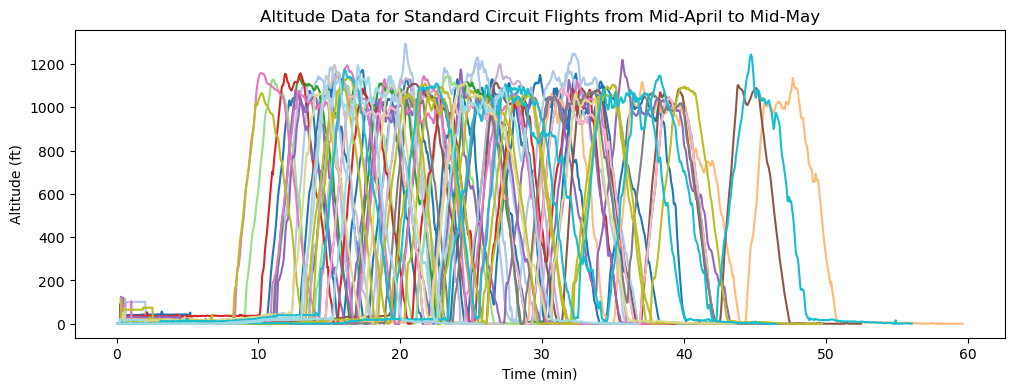

CPU times: total: 234 ms
Wall time: 376 ms


In [16]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1300:
        plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))


plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()

### Takeoff-Filtered Altitude Data

Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of Altitude per Time: 624.882 ft/min
Average Slope of Time per Altitude: 0.6 min/300 ft
Plotting...


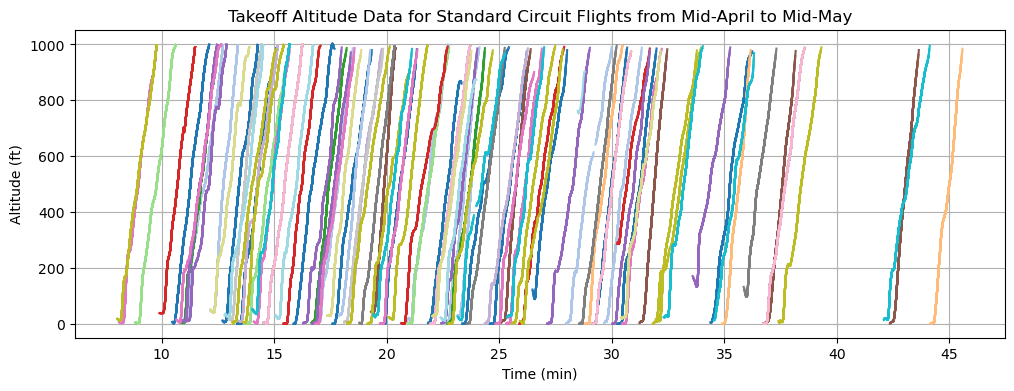

CPU times: total: 9.06 s
Wall time: 14.3 s


In [17]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_ft_per_min = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                # Stops indexing at 1000 when end index is greater than 1000
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # Finds average slope
                diff_alt_data = np.diff(alt_data)
                diff_time_data = np.diff(time_data)
                valid_indices = np.where(diff_time_data != 0)[0]
                slope_ft_per_min = diff_alt_data[valid_indices] / diff_time_data[valid_indices]
                slopes_ft_per_min.extend(slope_ft_per_min)

print('')
average_slope_ft_per_min = abs(np.mean(slopes_ft_per_min))
print(f"Average Slope of Altitude per Time: {round(average_slope_ft_per_min,3)} ft/min")
print(f"Average Slope of Time per Altitude: {round(1/average_slope_ft_per_min,3)*300} min/300 ft")
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Takeoff Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-24758-5821 [2%]

Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of Min per 300 ft: 0.458 min/300 ft
Plotting...


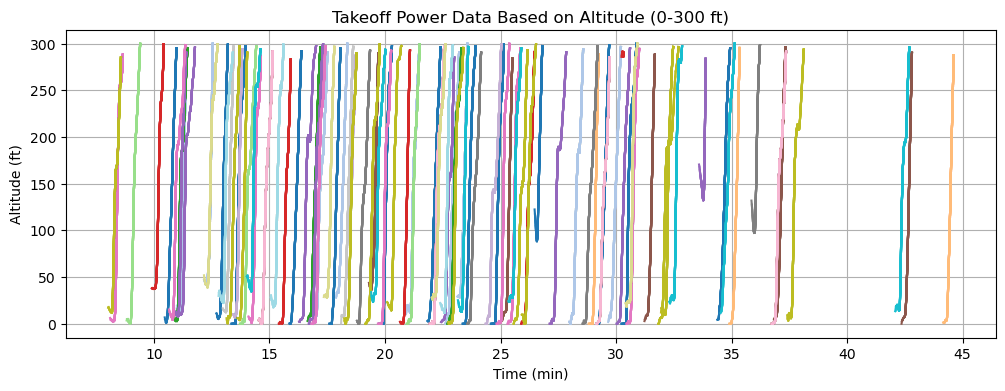

CPU times: total: 2.95 s
Wall time: 8.33 s


In [19]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 400
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))
print(f"Average Slope of Min per 300 ft: {round((1/average_slope_soc_per_ft)*300,3)} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of Min per 300 ft: 0.464 min/300 ft
Plotting...


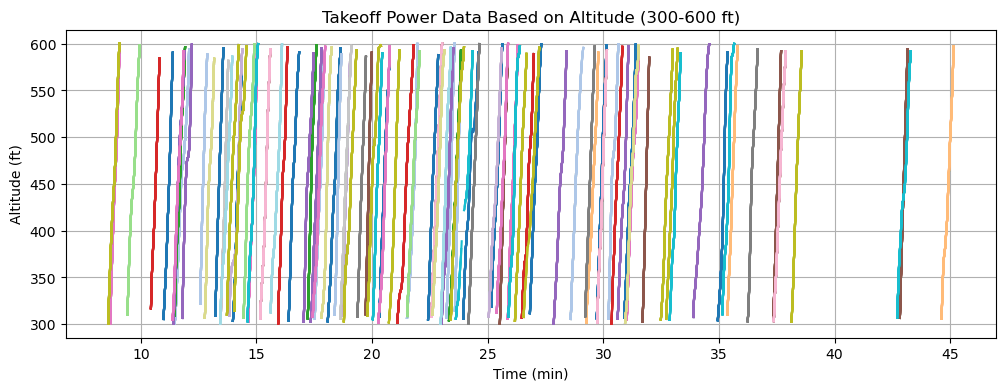

CPU times: total: 5.73 s
Wall time: 9.72 s


In [20]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))
print(f"Average Slope of Min per 300 ft: {round((1/average_slope_soc_per_ft)*300,3)} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of Min per 300 ft: 0.479 min/300 ft
Plotting...


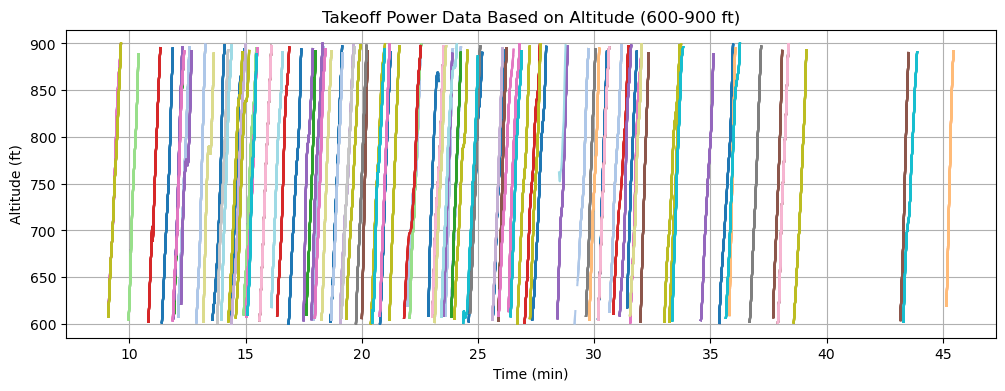

CPU times: total: 7.28 s
Wall time: 9.73 s


In [22]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))
print(f"Average Slope of Min per 300 ft: {round((1/average_slope_soc_per_ft)*300,3)} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()


### Takeoff Power Data

Processing file data/waterloo/flight/csv-25795-6179 [100%]
Plotting...


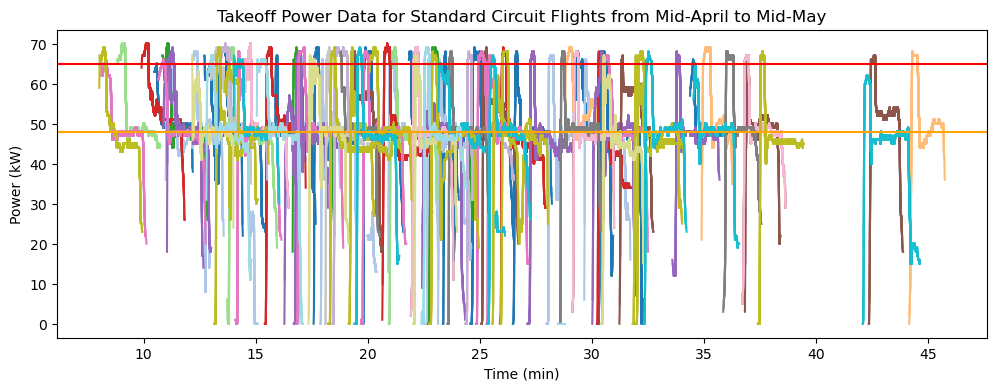

CPU times: total: 9.61 s
Wall time: 13.4 s


In [18]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.xlabel('Time (min)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Plotting...


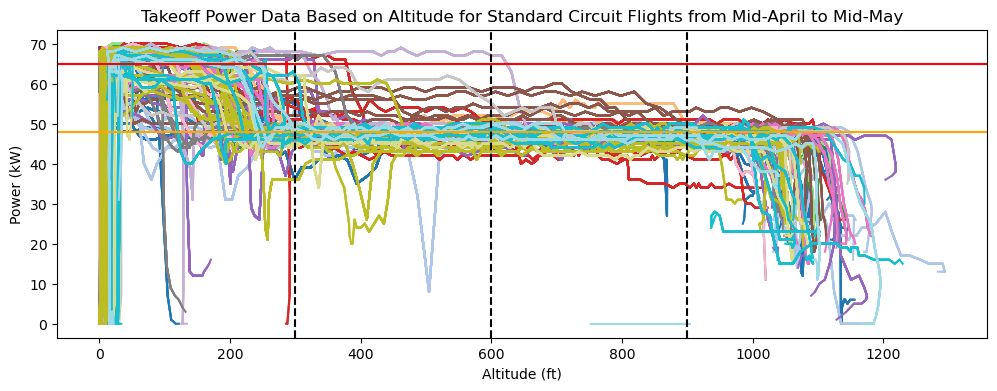

CPU times: total: 4.67 s
Wall time: 14.8 s


In [19]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["alt"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of Min per 300 ft: 60.505 kW/175 ft
Plotting...


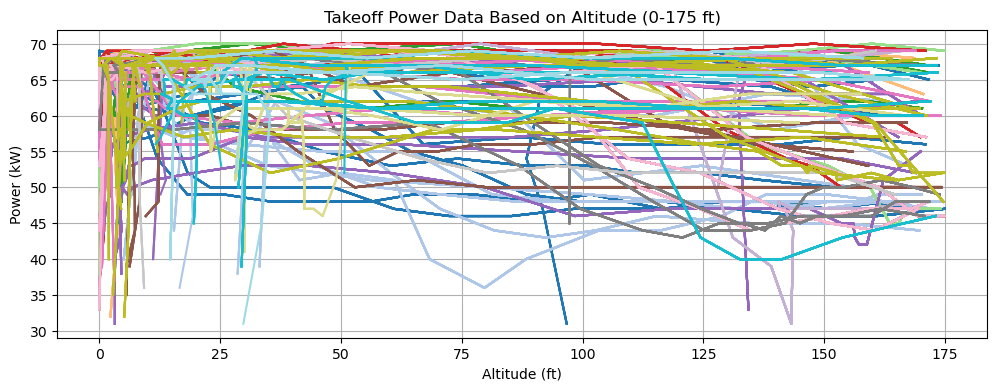

CPU times: total: 4.86 s
Wall time: 9.11 s


In [40]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 175:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                plt.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                
                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(filtered_pwr.mean())
print('')
average_power = abs(np.mean(power_list))
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} kW")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (0-175 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of Min per 300 ft: 51.974 kW/300 ft
Plotting...


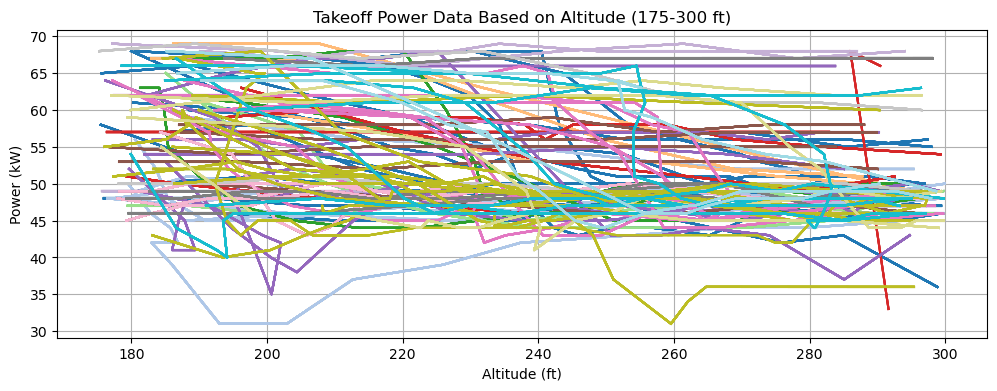

CPU times: total: 4.75 s
Wall time: 11.1 s


In [42]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 175:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                plt.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                
                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(filtered_pwr.mean())
print('')
average_power = abs(np.mean(power_list))
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} kW")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (175-300 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of Min per 300 ft: 48.273 kW/300 ft
Plotting...


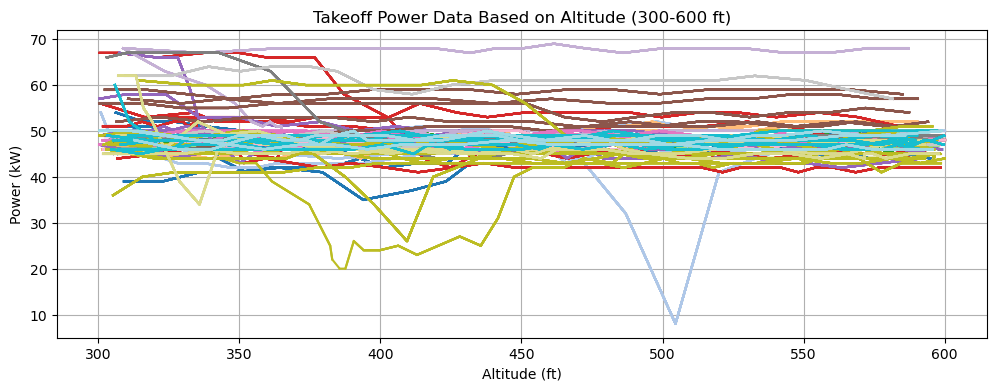

CPU times: total: 5.44 s
Wall time: 10.5 s


In [24]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(alt_data, pwr_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(df_power["kw"][i][start_idx:end_idx].mean())
print('')
average_power = abs(np.mean(power_list))
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} kW")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of Min per 300 ft: 47.5 kW
Plotting...


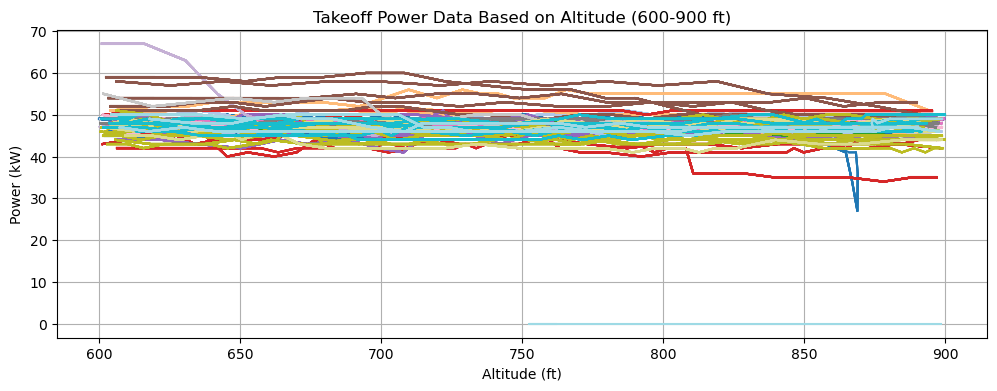

CPU times: total: 4.17 s
Wall time: 10.3 s


In [43]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(alt_data, pwr_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(df_power["kw"][i][start_idx:end_idx].mean())
print('')
average_power = abs(np.mean(power_list))
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} kW")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()


### Takeoff SoC Data

Processing file data/waterloo/flight/csv-24758-5821 [2%]

Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of SoC per Altitude: 7.049%/1000 ft
Plotting...


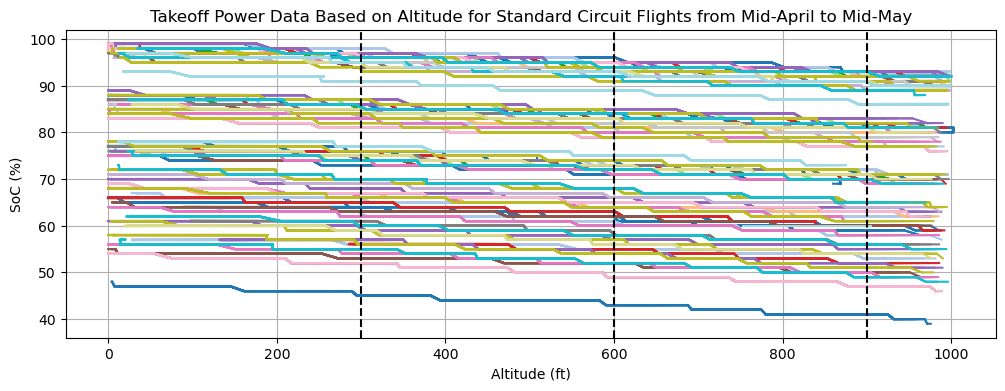

[]
CPU times: total: 7.08 s
Wall time: 16.3 s


In [54]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                diff_soc_data = np.diff(soc_data)
                diff_alt_data = np.diff(alt_data)
                valid_indices = np.where(diff_alt_data != 0)[0]
                slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                slopes_soc_per_ft.extend(slope_soc_per_ft)
               
                

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_soc_per_ft))*1000
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/1000 ft")
print("Plotting...")
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()
print(slopes_list)


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Plotting...


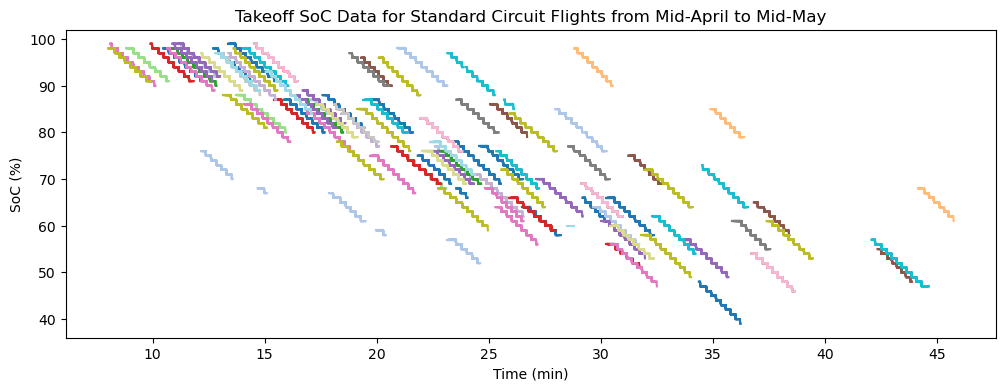

CPU times: total: 6.08 s
Wall time: 13.8 s


In [21]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('SoC (%)')
plt.title('Takeoff SoC Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


### Takeoff OAT Data

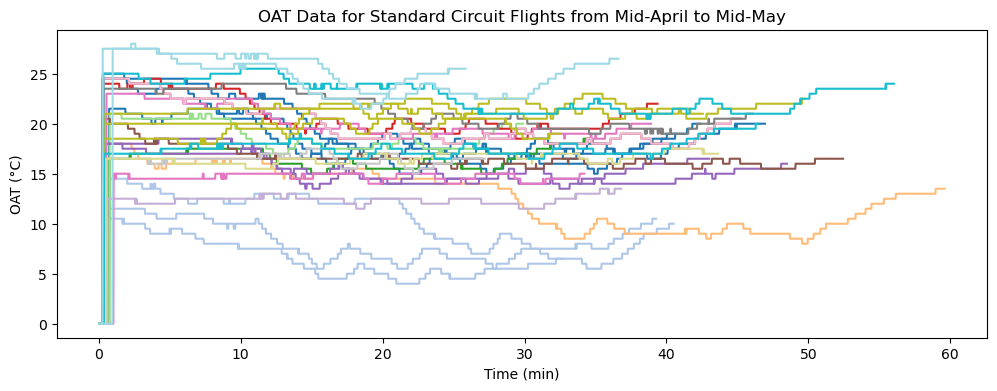

CPU times: total: 172 ms
Wall time: 369 ms


In [22]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1400:
        first_non_zero = df_power["oat"][i].loc[df_power["oat"][i] != 0].iloc[0]
        df_power.loc[df_power["oat"][i] == 0, 'A'] = first_non_zero
        plt.plot(df_power["time"][i], df_power["oat"][i],color=colormap(i / total_subfolders))


plt.xlabel('Time (min)')
plt.ylabel('OAT (°C)')
plt.title('OAT Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()

Processing file data/waterloo/flight/csv-25795-6179 [100%]
Plotting...


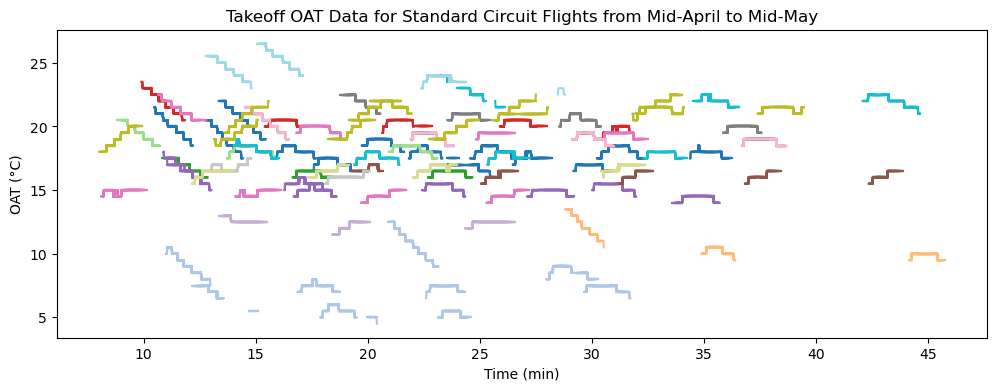

CPU times: total: 6.17 s
Wall time: 13.4 s


In [23]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["oat"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('OAT (°C)')
plt.title('Takeoff OAT Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


### Altitude Separation

Processing file data/waterloo/flight/csv-24758-5821 [2%]

Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of SoC per Altitude: 5.351%/300 ft
Plotting...


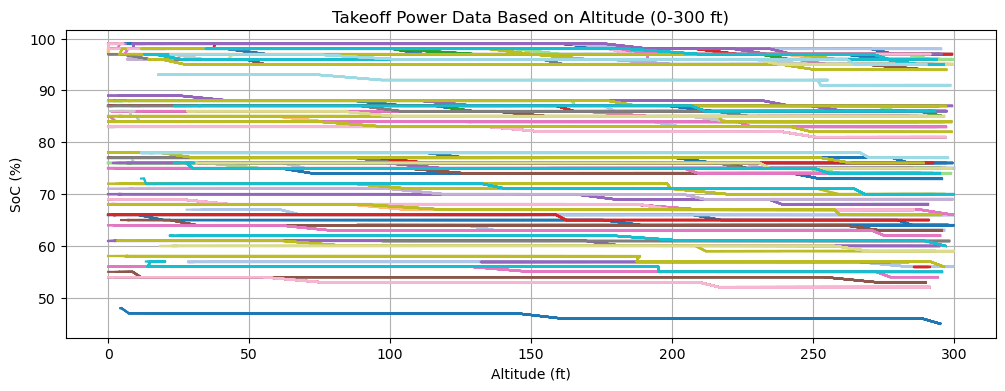

CPU times: total: 4.97 s
Wall time: 8.67 s


In [9]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
                
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))
                
                

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300 
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of SoC per Altitude: 1.364%/300 ft
Plotting...


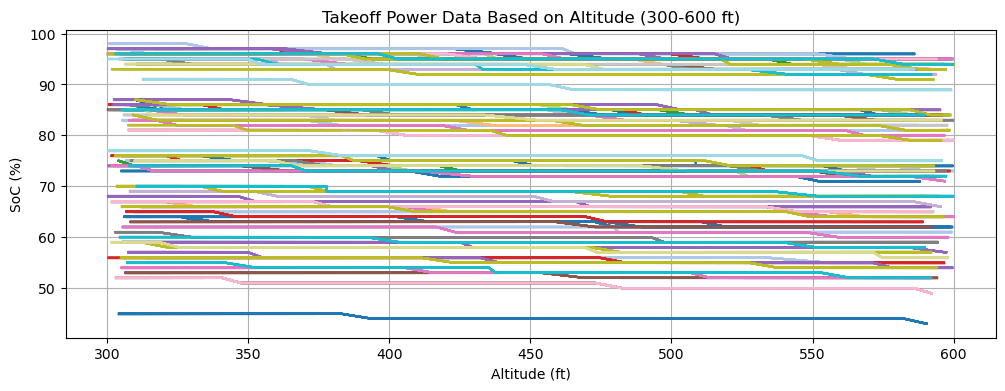

CPU times: total: 7.59 s
Wall time: 10.3 s


In [7]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-24758-5821 [2%]

Processing file data/waterloo/flight/csv-25795-6179 [100%]
Average Slope of SoC per Altitude: 2.909%/300 ft
Plotting...


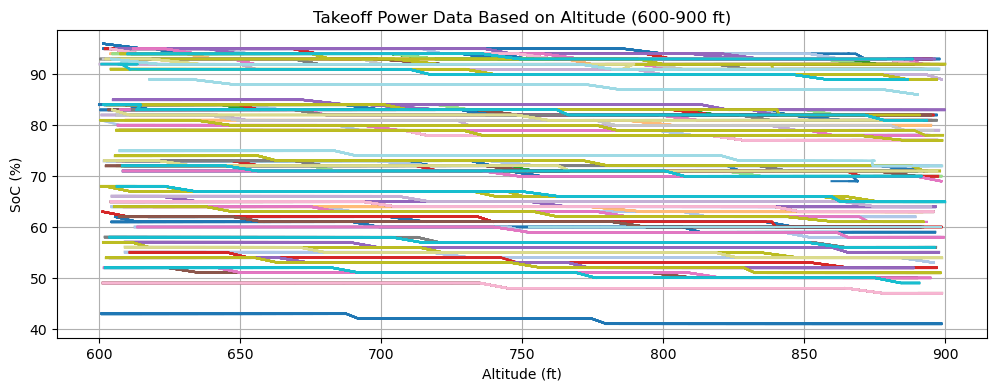

CPU times: total: 7.52 s
Wall time: 10.2 s


In [8]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()
